<a href="https://colab.research.google.com/github/mibeaum/ML/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time series classification**



Load Python modules

In [6]:
import numpy as np  # Arrays, matrices and functions on them. Required by Pandas, below
import pandas as pd # A data analysis library
from sklearn.model_selection import train_test_split # scikit-learn, machine learning tools
import matplotlib.pyplot as plt # A plotting library
import seaborn as sns # Built on matplotlib, facilitates aesthetically pleasing plots
from sklearn import cluster
import datetime

# General settings
sns.set_style('whitegrid') # Plots will have a white grid
# Variables that will help us work with the classes
class_names = ['workstation', 'server']
class_colors = ['darkorange', 'steelblue']
kmeans2 = cluster.KMeans(n_clusters=2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Functions

In [7]:
def load_data(filename):
    ''' Load the data from a file in a GitHub repo '''
    url_root = 'https://raw.githubusercontent.com/mibeaum/ML/master'
    url = url_root+'/'+filename
    mydateparser = lambda x: ( 
       # pd.to_datetime(x, format="%d/%m/%Y%H:%M:%S").strftime("%H%M%S")
       pd.to_datetime(x, format="%d/%m/%Y%H:%M:%S").time
    )    
    df = pd.read_csv(url, sep=',', header=0, usecols = ["server", "dateTime", "internalPacketIdentifier"], parse_dates=['dateTime'], date_parser=mydateparser) # Use Pandas to load the data into a Pandas DataFrame
    print('Loaded from', url)
    data = df.values # Convert from a Pandas DataFrame to a numpy array
    print('The shape of data is', data.shape)
    print('')
    return df

def plot_data_samples(df, labels):
    ''' Plot the time series data relating to the input list of sample numbers '''
    my_day = datetime.date(1970, 11, 7)
    x_dt = [ datetime.datetime.combine(my_day, t) for t in df['dateTime'] ]
    plt.scatter(x_dt, df['server'])

    x_dt_min = datetime.datetime.combine(my_day, datetime.datetime.min.time())
    x_dt_max = datetime.datetime.combine(my_day, datetime.datetime.max.time())

    xlabels = [x.strftime("%H%M%S") for x in x_dt]
    plt.xticks(x_dt,xlabels)

    ylabels = [x for x in df['server']]
    plt.yticks(df['server'], ylabels)

    print('')
    #plt.set ylim([00.00, 23.59])
    plt.title('workstation (class 0): server (class 1)')
    plt.ylabel('Server')
    plt.xlabel('Time')    

Load the data

In [22]:
filename = 'data.csv'
df = load_data(filename) 
data_log = df.values # Convert from a Pandas DataFrame to a numpy array
print('These are the first 7 rows of data_log:\n', data_log[0:7], '\n')

Loaded from https://raw.githubusercontent.com/mibeaum/ML/master/data.csv
The shape of data is (42, 3)

The data is a matrix. These are the first 7 rows of data:
 [[0 datetime.time(8, 11, 10) '0000026335FA1560']
 [0 datetime.time(9, 23, 2) '0000026335FA1560']
 [1 datetime.time(19, 30, 22) '0000026335C83DB0']
 [1 datetime.time(20, 3, 23) '0000026335C83DB0']
 [0 datetime.time(10, 19, 31) '0000026338FC9920']
 [0 datetime.time(11, 23, 21) '0000026338FC9920']
 [0 datetime.time(11, 30, 12) '00000263351894F0']] 



Process the data

In [33]:
labels = data_log[:,0].astype(int)
data = data_log[:,1:]
print('The shape of the labels vector is', labels.shape)
print('The shape of the data matrix is', data.shape)
print('These are the first 7 elements of labels vector:\n', labels[0:7], '\n')
print('These are the first 7 rows of data matrix:\n', data[0:7], '\n')



The shape of the labels vector is (42,)
The shape of the data matrix is (42, 2)
These are the first 7 elements of labels vector:
 [0 0 1 1 0 0 0] 

These are the first 7 rows of data matrix:
 [[datetime.time(8, 11, 10) '0000026335FA1560']
 [datetime.time(9, 23, 2) '0000026335FA1560']
 [datetime.time(19, 30, 22) '0000026335C83DB0']
 [datetime.time(20, 3, 23) '0000026335C83DB0']
 [datetime.time(10, 19, 31) '0000026338FC9920']
 [datetime.time(11, 23, 21) '0000026338FC9920']
 [datetime.time(11, 30, 12) '00000263351894F0']] 



Plot the data

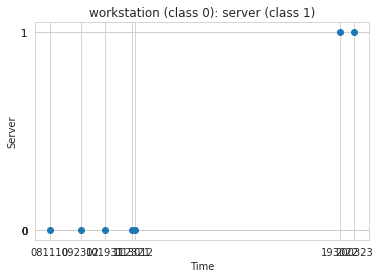

In [34]:
plot_data_samples(df[0:7], labels) 

Split the data set

In [36]:
final_test_set_size = 7

# Use the train_test_split from the scikit-learn (sklearn) module
data_dev, data_finaltest, labels_dev, labels_finaltest = train_test_split(
    data, labels, test_size=final_test_set_size, random_state=21, stratify=labels)
